C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\DuchJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


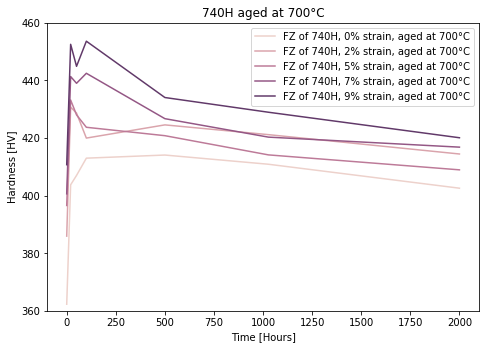

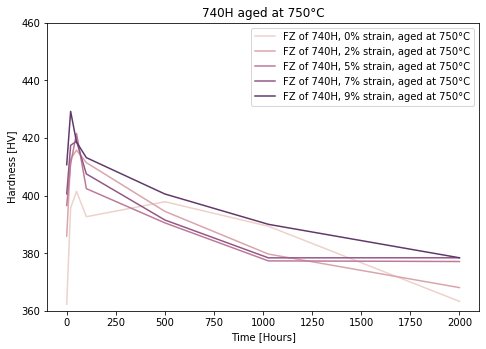

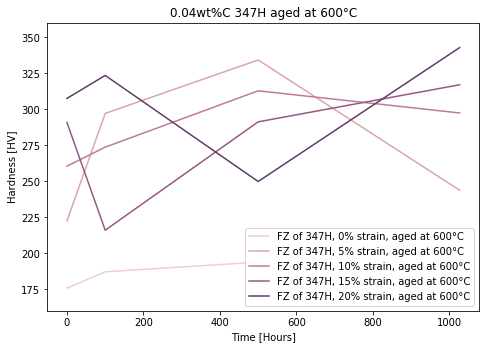

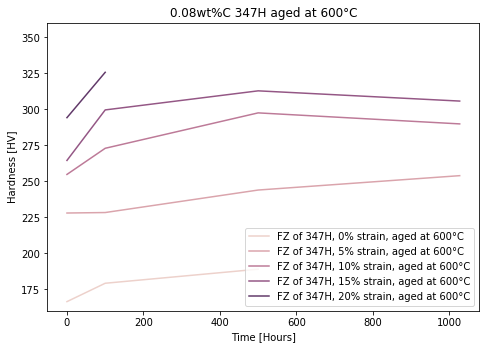

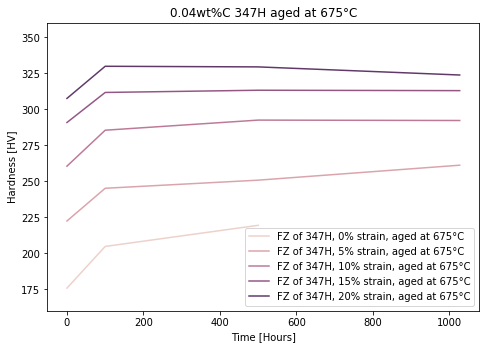

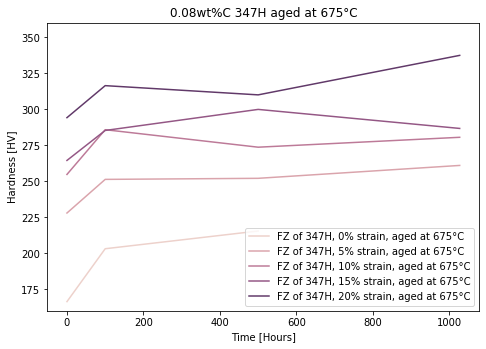

In [195]:
'''
This program takes the csv document of all my data that is produced by the python program Get_data_v1
it then pulls out all the information into a dataframe
then we plot it to prove it to ourselves that it works
'''

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import math
from operator import itemgetter
import re

#this function converts an array thats in string form into an array object
#UPDATE 10/9 no longer need this function, there's an easier way
def convert (str_array):
    array = list(str_array.split("["))
    array = list(array[1].split("]"))
    array = list(array[0].split(" "))
    
    real_array = []
    for x in array:
        real_array.append(int(x))
    
    return real_array

#this function simply finds the average value from an array. This gives us a point to plot instead 
# of a list of intergers. This is it's own function so it can be called in a loop later
def average_array (str_array):
    array = convert (str_array)
    average = sum(array)/len(array)
    
    return average

#This function refines the original dataframe so it only outputs the data of the subset listed:
#hardness type (HAZ, FZ, or BM), material type (347H or 740H), strain (0 to 20 pct), and temperature (600, 675, 700 or 750)
#it then creates two arrays, one with time data, the other with average hardness data
#it then returns the original array
#'''
def plot_average (hardness, hardness_type, material, strain, temperature):
    summation = 0
    average_list = []
    
    #this for loop is giving an average value for an array, and creating a list of (time, average hardness)
    for index in hardness.index.values:
        array = hardness.at[index,'Hardness']
        average_value = average_array (array)
        #average_list.append(average_value)
        #time.append(hardness.at[index, 'Time'])
        average_list.append([hardness.at[index, 'Time'], average_value])
    
    #now we have to sort our list of lists by time
    average_list = sorted(average_list, key=itemgetter(0))
    
    #to plot we need an array of x values and y values, but they're both together, so lets separate them with a loop
    time_x = [] #x-value
    hardness_y = [] #y-value
    for item in average_list:
        time_x.append(item[0])
        hardness_y.append(item[1])
        
    return (time_x, hardness_y)

'''
this function will extract the set of hardness data (in array form) that 
corresponds to a given composition, strain,
temperature, and type (BM, FZ, or HAZ). Once we have this, 
we can call plot_average and get the plot
'''
def plot_set (hardness, material, strain, temperature, hardness_type):
    re_array = ['Material', material, 'Strain', strain, 'Temperature', temperature, 'Type', hardness_type]
    
    #this loop takes the whole set of data and refines it down to the set that matches the given information
    count = 0
    for x in range(4):
        hardness = hardness[hardness[re_array[count]]==re_array[count+1]]
        count +=2
          
    (time_x, hardness_y) = plot_average (hardness, hardness_type, material, strain, temperature)
    
    return (hardness, time_x, hardness_y)

#this function is the same as the above function, except that it includes composition
#i ran into issues with calling composition for 740H as each of it's rows is a NaN value
#this refines the data 
def plot_set_347H (hardness, material, composition, strain, temperature, hardness_type):
    re_array = ['Material', material, 'Composition', composition, 'Strain', strain, 'Temperature', temperature, 'Type', hardness_type]
    
    #this loop takes the whole set of data and refines it down to the set that matches the given information
    count = 0
    for x in range(5):
        hardness = hardness[hardness[re_array[count]]==re_array[count+1]]
        count +=2
          
    (time_x, hardness_y) = plot_average (hardness, hardness_type, material, strain, temperature)
    
    return (hardness, time_x, hardness_y)

#this is where we plot the data
def graph_data (hardness):
    %matplotlib inline
    sns.set_palette(sns.cubehelix_palette())
    
    #List unique values in the hardness dataframe['Strain'] column
    strain_list = hardness.Strain.unique()
    strain_list.sort()
    #lets get a list of all the different attributes
    temp_list = hardness.Temperature.unique()
    #type_list = hardness.Type.unique() #for now lets just do FZ for now
    type_list = ['FZ']
    material_list = hardness.Material.unique()
    
    counting_plots = 1 #the number of figures is equal to the temperatures we're using
    
    #'''
    
    #plotting data occurs in a loop so we can plot all of the data
    #we have nested for loops as we want a new plot for each material and for each temperature
    for material in material_list:
        for temperature in temp_list:
            
            if material == '347H':
                composition_list = hardness.Composition.unique()

                for composition in composition_list:
                    
                    #these lines actually make the plot, move this around to create more or less plots
                    #everytime this loop runs it creates a new plot
                    #since this is under material and temperature, both material and temp will be given new plots
                    #if we want composition to each have their own plots, switch compositionw with strain in the for loops
                    #and move these lines after the for loop
                    fig = plt.figure(counting_plots)
                    ax = fig.add_axes([0,0,1,1])
                    ax.set_title("{}wt%C {} aged at {}°C" .format(composition, material, temperature))
                    ax.set_xlabel('Time [Hours]')
                    ax.set_ylabel('Hardness [HV]')
                
                    for strain in strain_list:
                        
                        #we call plot_set_347H to get our x and y values to plot
                        (hardness_specific, time_x, hardness_y) = plot_set_347H (hardness, material, composition, strain, temperature, 'FZ')
                        #title = ("{} of {} {}, {}% strain, aged at {}°C" .format('FZ', composition, material, strain, temperature))
                        title = ("{} of {}, {}% strain, aged at {}°C" .format('FZ', material, strain, temperature))
                        
                        #this is very important, most of these options will leave us with blank x and y values
                        #for example, we have four temperatures (600, 675, 700, 750) but each material was only heated
                        #to two of these temperatures, the hardness data for 347H aged at 700 and 750 will be blank
                        #thus, we only plot the data where there is something, easiest way is just to see if the
                        #hardness array has zero length. I'm sure there's a better way, but this works fine.
                        if len(hardness_specific) != 0:
                            #print (("{}wt%C at {}% strain {}°C\n" .format(composition, strain, temperature)), time_x, '\n', hardness_y, '\n break')
                            
                            plt.plot(time_x, hardness_y, label=title)#'''
                            #lets insert our legend
                            plt.legend()
                            #rescale our y axis
                            pylab.ylim([160,360])
                            #insert a title and x and y scale bars
                            
                            counting_plots += 1
            
            #this is doing the same thing as the if statement above, but for 740H
            #only difference is that we don't have composition
            #read my comments above, this should be similar code
            else:     
                fig = plt.figure(counting_plots)
                ax = fig.add_axes([0,0,1,1])

                for strain in strain_list:
                    (hardness_specific, time_x, hardness_y) = plot_set (hardness, material, strain, temperature, 'FZ')
                    #since we don't have composition, it's not in the title
                    title = ("{} of {}, {}% strain, aged at {}°C" .format('FZ', material, strain, temperature))
                    
                    if len(hardness_specific) != 0:
                        plt.plot(time_x, hardness_y, label=title)#'''
                        #lets insert our legend
                        plt.legend()
                        #rescale our y axis
                        pylab.ylim([360,460])
                        #insert a title and x and y scale bars
                        ax.set_title("{} aged at {}°C" .format(material, temperature))
                        ax.set_xlabel('Time [Hours]')
                        ax.set_ylabel('Hardness [HV]')
                        counting_plots += 1
        
#grab the hardness from the local file, change this if you're not me and you have a different document
hardness = pd.read_csv(r'C:\Users\DuchJ\Desktop\Machine_Learning_Class\Final_Project\Final_Project_Code\all_data.csv')
#now we have the CSV read into a dataframe, call the function which calls the other functions and get it going
hard_test = graph_data(hardness)

In [22]:
'''
file_id = '0BwwA4oUTeiV1UVNwOHItT0xfa2M'
request = drive_service.files().get_media(fileId=file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print "Download %d%%." % int(status.progress() * 100)

tre


True
